In [7]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
#from qiskit.tools.jupyter import *
from qiskit.visualization import *
#from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
#IBMQ.save_account('')
#provider = IBMQ.load_account()

In [8]:
#from ibm_quantum_widgets import CircuitComposer
from qiskit import QuantumRegister, ClassicalRegister, execute
#from qiskit_ibm_runtime import QiskitRuntimeService
#%matplotlib inline
import matplotlib.pyplot as plt
import itertools


N = 3
sigma = 2.5
mu = 4.5

QRn = N+2
CRn = N+2
qreg_q = QuantumRegister(QRn, 'q')
creg_c = ClassicalRegister(CRn, 'c')
circuit = QuantumCircuit(qreg_q, creg_c)

#CnNOT

def X_bit_s(s):
    i = 0
    while (s != 0):
        if(s & 1):
            circuit.x(i)
        i = i + 1
        s = s >> 1

def CnNOT_step(list, c):
    if(len(list) >= 2):
        i = len(list) - 2
        circuit.ccx(list[len(list)-2], list[len(list)-1], c)
    else:
        i = len(list)
    
    while(i != 0 and i != 1):
        circuit.ccx(list[i-2], list[i-1], list[i])
        i -= 2
    
    if(i == 1):
        circuit.cx(list[0], list[i])
        i += 2
    else:
        i += 4
    
    while(i < len(list)):
        circuit.ccx(list[i-2], list[i-1], list[i])
        i += 2

def CnNOT(list, c, a):
    if(len(list) == 1):
        circuit.cx(list[0], c)
        return
    elif(len(list) == 2):
        circuit.ccx(list[0], list[1], c)
        return

    if(len(list) % 2 == 1):
        temp = list[1:]
    else:
        temp = list[2:]
    temp.append(a)

    CnNOT_step(list, a)
    CnNOT_step(list, a)
    circuit.barrier(np.arange(min(list), max(list)+1))
    CnNOT_step(temp, c)
    CnNOT_step(temp, c)
    circuit.barrier(np.arange(min(list), max(list)+1))
    CnNOT_step(list, a)
    CnNOT_step(list, a)
    circuit.barrier(np.arange(min(list), max(list)+1))
    CnNOT_step(temp, c)
    CnNOT_step(temp, c)

def norm_(sigma_, mu_, N):
    return np.sum(np.exp((-(np.arange(-N, N+1, 1) - mu_)**2)/float(sigma_**2)))

def angle_(sigma_, mu_, N=10**3):
    return np.arccos(np.sqrt(norm_(sigma_/2., mu_/2., N)/norm_(sigma_, mu_, N)))

def qubit_strings(n):
    qubit_strings = []
    for q in itertools.product(['0', '1'], repeat=n):
        qubit_strings.append(''.join(q))
    return qubit_strings

def mean_qubit_combo(qub, mu):
    mu_out = mu
    for bit in qub:
        mu_out = (mu_out/2.) - ((1/2.)*int(bit))
    return mu_out

def level_means(mu, n):
    list_mu_out = []
    qb_strings = qubit_strings(n)
    for qb in qb_strings:
        mu_out = mean_qubit_combo(qb, mu)
        list_mu_out.append(mu_out)
    return list_mu_out

def level_angles(sigma, mu, n):
    sigma_out = sigma/(2.**n)
    list_mu = level_means(mu, n)
    # for each (sigma, mu) pair, calculate the corresponding angle
    angles_out = []
    for mu_ in list_mu:
        angles_out.append(angle_(sigma_out, mu_))
    return angles_out


angle = level_angles(sigma, mu, 0)
circuit.ry(2*angle[0], 0)

start = 0
temp = [1]
for i in range(1, N):
    angles = level_angles(sigma, mu, i)
    
    end = i+1
    for k in range(start, (end + start) // 2, 1):
           circuit.swap(k, end + start - k - 1)
            
    for j in range(2**(i)):
        circuit.barrier(np.arange(0, N+2))
        X_bit_s((2**(i) - j - 1) << 1)
        CnNOT(temp, N, N+1)
        circuit.cry(2*angles[j], N, 0)
        CnNOT(temp, N, N+1)
        X_bit_s((2**(i) - j - 1) << 1)
        
    for k in range(start, (end + start) // 2, 1):
            circuit.swap(k, end + start - k - 1)    
        
    circuit.barrier(np.arange(0, N+2))
    temp.append(i+1)

for i in range(0, N, 1):
   circuit.measure(qreg_q[i], creg_c[i])

#editor = CircuitComposer(circuit=circuit)
#editor
#circuit.draw("mpl")


Total count are: {'00011': 31724, '00010': 16961, '00101': 43323, '00110': 31516, '00100': 43257, '00111': 17013, '00000': 8114, '00001': 8092}


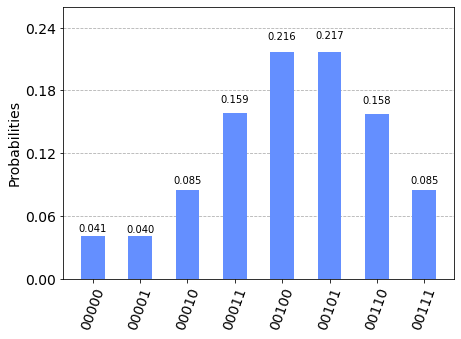

In [9]:
#ibmq_noise_model = provider.get_backend('ibmq_quito')

#simulator = QasmSimulator.from_backend(ibmq_noise_model)

simulator = QasmSimulator()

# compile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
compiled_circuit = transpile(circuit, simulator)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=200000)

#QC
#job = execute(circuit, backend=ibmq_noise_model, shots=8192)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(compiled_circuit)
print("\nTotal count are:",counts)

# Draw the circuit
#circuit.draw()

# Plot a histogram
plot_histogram(counts)


Total count are: {'00010': 17103, '00011': 31438, '00110': 31547, '00111': 17084, '00101': 43229, '00100': 43283, '00001': 8128, '00000': 8188}


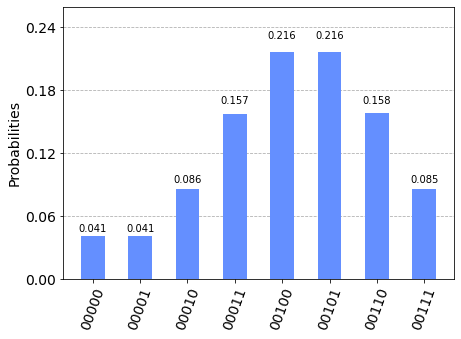

In [10]:
from qiskit import BasicAer
backend = BasicAer.get_backend('qasm_simulator')
circ = transpile(circuit, backend, basis_gates=['u1','u2','u3','cx'])
job = backend.run(circ, shots=200000)
result = job.result()

# Returns counts
counts = result.get_counts(circ)
print("\nTotal count are:",counts)

# Draw the circuit
#circuit.draw()

# Plot a histogram
plot_histogram(counts)


Total count are: {'00111': 1695, '00000': 778, '00100': 4312, '00001': 843, '00101': 4315, '00110': 3166, '00011': 3217, '00010': 1674}


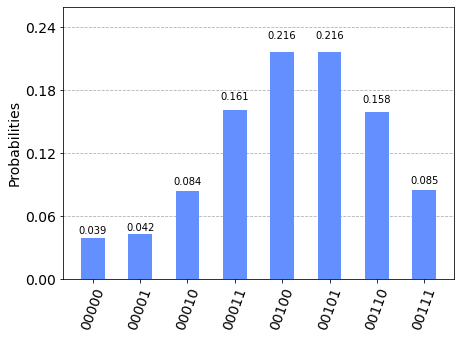

In [12]:
#ibmq_noise_model = provider.get_backend('ibmq_quito')

#simulator = QasmSimulator.from_backend(ibmq_noise_model)

simulator = QasmSimulator()

# compile the circuit down to low-level QASM instructions
# supported by the backend (not needed for simple circuits)
compiled_circuit = transpile(circuit, simulator)

# Execute the circuit on the qasm simulator
job = simulator.run(compiled_circuit, shots=20000)

#QC
#job = execute(circuit, backend=ibmq_noise_model, shots=8192)

# Grab results from the job
result = job.result()

# Returns counts
counts = result.get_counts(compiled_circuit)
print("\nTotal count are:",counts)

# Draw the circuit
#circuit.draw()

# Plot a histogram
plot_histogram(counts)